# Sales Prediction using Recurrent Neural Networks

## Importing the libraries and the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv('./sales.csv', parse_dates = True, index_col = 'DATE')
df.columns = ['sales']
df

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<Axes: xlabel='DATE'>

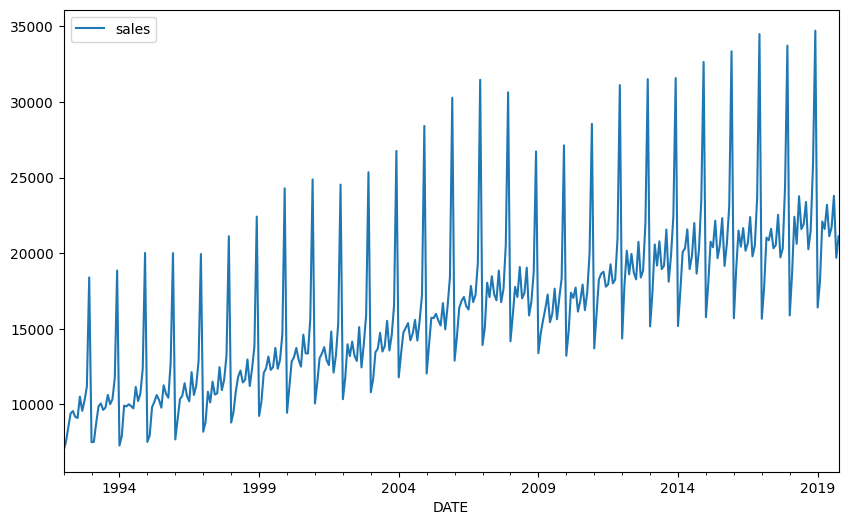

In [3]:
df.plot(figsize = (10, 6))

In [4]:
len(df)-24

310

In [5]:
test_size = 24
test_ind = len(df) - test_size

In [6]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
train

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [8]:
test

,sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Timeseries Generator

In [11]:
length = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = 1)

x, y = generator[0]

print(x)
print()
print(y)

[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]

[[0.02047633]]


## Model Creation

In [12]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

## Training the model

In [14]:
model.fit(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 10s 20ms/step - loss: 0.0278 - val_loss: 0.0263
Epoch 2/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0184 - val_loss: 0.0199
Epoch 3/20
298/298 [==============================] - 3s 8ms/step - loss: 0.0112 - val_loss: 0.0168
Epoch 4/20
298/298 [==============================] - 3s 8ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 5/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 6/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 7/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 7.6990e-04
Epoch 8/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0013 - val_loss: 0.0079
Epoch 9/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 7.4447e-04
Epoch 10/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0011 - val_

<Axes: >

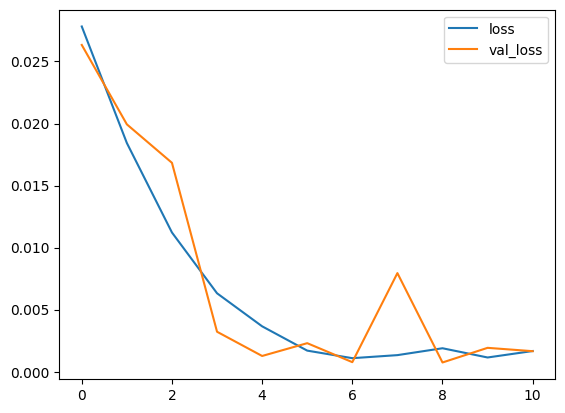

In [15]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [16]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:, 1:], [current_pred], axis = 1)

1/1 [==============================] - 0s 24ms/step


In [17]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test

<ipython-input-17-81ff6aecbb8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,sales,Predictions
DATE,,
2017-11-01,24438,23151.767066
2017-12-01,33720,33122.839224
2018-01-01,15881,17094.589126
2018-02-01,18585,18596.682328
2018-03-01,22404,21000.008630
2018-04-01,20616,20835.841805
2018-05-01,23764,21404.414423
2018-06-01,21589,20428.429967
2018-07-01,21919,20573.853749


<Axes: xlabel='DATE'>

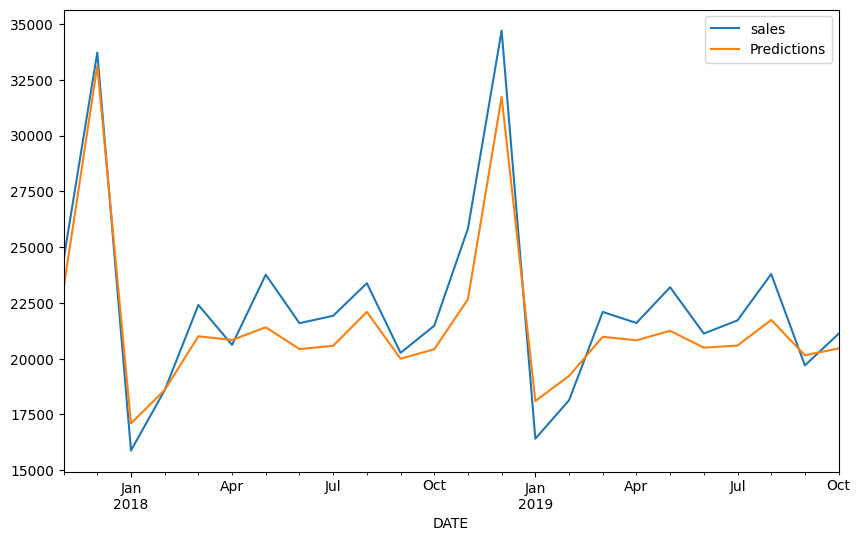

In [18]:
test.plot(figsize = (10, 6))

## Final Model Creation

In [19]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [20]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, batch_size = 1, length = length)

In [21]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

model.fit(generator, epochs = 10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
322/322 [==============================] - 4s 9ms/step - loss: 0.0242
Epoch 2/10
322/322 [==============================] - 4s 12ms/step - loss: 0.0191
Epoch 3/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0106
Epoch 4/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0059
Epoch 5/10
322/322 [==============================] - 4s 12ms/step - loss: 0.0027
Epoch

In [22]:
forecast = []
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch = np.append(current_batch[:, 1:], [current_pred], axis = 1)

1/1 [==============================] - 0s 24ms/step


In [23]:
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq='MS')
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

<Axes: xlabel='DATE'>

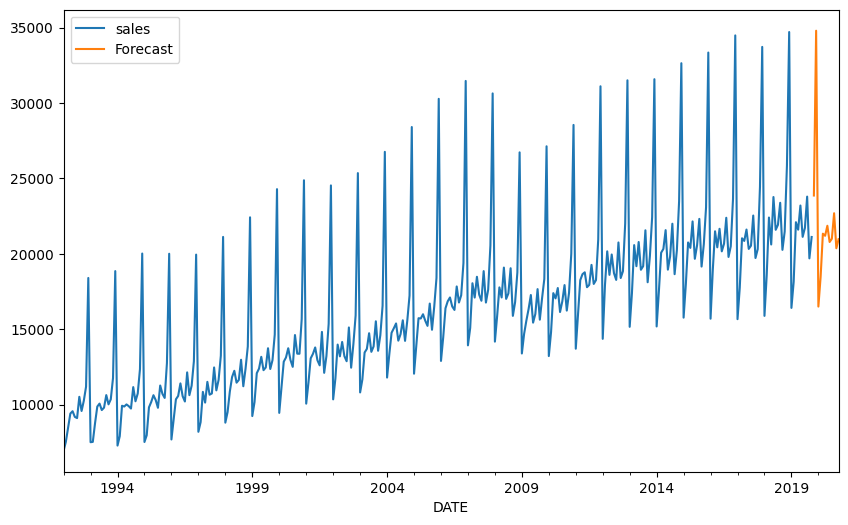

In [24]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize = (10, 6))

(576.0, 611.0)

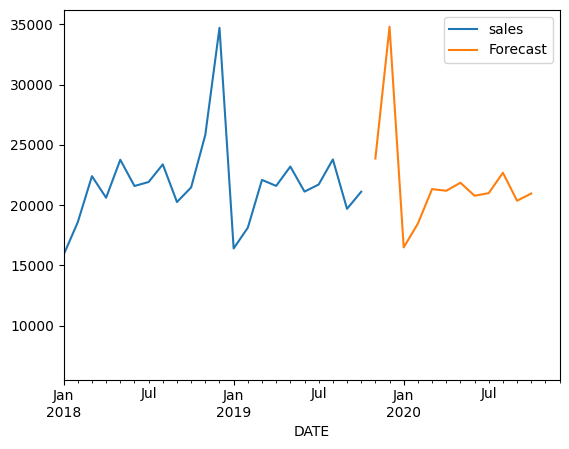

In [25]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')